# Knowledge distillation
Based on this awesome paper [https://arxiv.org/abs/1503.02531](Distilling the Knowledge in a Neural Network, by Geoffrey Hinton, Oriol Vinyals, Jeff Dean). Made in a rysh, escuse any brevity

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [7]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1) #Before: (N, 28, 28) After: (N, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)

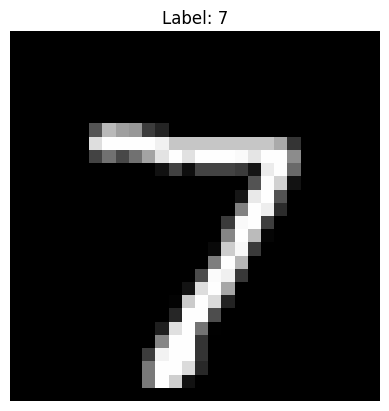

Label: 7


In [8]:
sample_image = x_test[0]
sample_label = y_test[0]

# Plot the image
plt.imshow(sample_image, cmap="gray")
plt.title(f"Label: {sample_label}")
plt.axis("off")
plt.show()

print("Label:", sample_label)

In [9]:
#We will follow the original input and flatten it to use a DNN:
# Flatten the MNIST inputs
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [10]:
# Create early stopping callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=3,          # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore model weights from best epoch
)
#Create Hinton-style teacher (fully connected)
def create_teacher():
    model = keras.Sequential([
        layers.Input(shape=(784,)),                 # Flattened MNIST input
        layers.Dense(1200, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1200, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10)                            # Output logits
    ])
    return model

# Compile and train teacher
teacher = create_teacher()
teacher.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
teacher.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.1,callbacks=[early_stopping])
teacher.evaluate(x_test, y_test)

Epoch 1/50
844/844 [==============================] - 25s 28ms/step - loss: 0.2770 - accuracy: 0.9147 - val_loss: 0.1026 - val_accuracy: 0.9668
Epoch 2/50
844/844 [==============================] - 20s 24ms/step - loss: 0.1484 - accuracy: 0.9552 - val_loss: 0.0776 - val_accuracy: 0.9782
Epoch 3/50
844/844 [==============================] - 3112s 4s/step - loss: 0.1222 - accuracy: 0.9636 - val_loss: 0.0884 - val_accuracy: 0.9750
Epoch 4/50
844/844 [==============================] - 800s 949ms/step - loss: 0.1041 - accuracy: 0.9685 - val_loss: 0.0720 - val_accuracy: 0.9783
Epoch 5/50
844/844 [==============================] - 3254s 4s/step - loss: 0.0966 - accuracy: 0.9704 - val_loss: 0.0674 - val_accuracy: 0.9800
Epoch 6/50
844/844 [==============================] - 1366s 2s/step - loss: 0.0869 - accuracy: 0.9736 - val_loss: 0.0738 - val_accuracy: 0.9795
Epoch 7/50
844/844 [==============================] - 9502s 11s/step - loss: 0.0858 - accuracy: 0.9746 - val_loss: 0.0742 - val_accura

[0.06259342283010483, 0.9830999970436096]

In [11]:
# Create Hinton-style student (1 hidden layer, 300 units)
def create_student():
    model = keras.Sequential([
        layers.Input(shape=(784,)),          # Flattened input
        layers.Dense(300, activation='relu'),
        layers.Dense(10)                     # Output logits
    ])
    return model

student = create_student()

## Softmax Temperature in Knowledge Distillation

This plot shows how the temperature parameter \(T\) affects the softmax output distribution in knowledge distillation:

![Softmax Temperature Scaling](https://miro.medium.com/max/875/1*YJ9b9uF7jUu7m3t0h6y7Jg.png)

- **T = 1**: Standard softmax with sharp, confident predictions.
- **T > 1**: Softens the probability distribution, revealing more information about less likely classes.
- **T → ∞**: Produces a uniform distribution over classes.

Higher temperature values help the student model learn better from the teacher's softened outputs by capturing relative similarities between classes.

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Custom model to train student with knowledge distillation from teacher
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()                  # Initialize base keras.Model
        self.student = student              # Student model to be trained
        self.teacher = teacher              # Pre-trained teacher model (frozen during distillation)

    def compile(self, optimizer, metrics,
                student_loss_fn, distillation_loss_fn,
                alpha=0.1, temperature=10):    # Original paper uses temperature=10
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn          # Hard label loss (e.g. sparse categorical crossentropy)
        self.distillation_loss_fn = distillation_loss_fn  # Soft label loss (e.g. KL divergence)
        self.alpha = alpha                              # Weight balancing hard vs soft loss
        self.temperature = temperature                  # Temperature to soften logits

    def train_step(self, data):
        x, y = data                                     # Unpack inputs and labels

        # Get teacher predictions (logits) in inference mode
        teacher_logits = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Student predictions (logits)
            student_logits = self.student(x, training=True)

            # Compute hard label loss between true labels and student logits
            student_loss = self.student_loss_fn(y, student_logits)

            # Compute distillation loss between softened teacher and student probabilities
            distill_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_logits / self.temperature, axis=1),
                tf.nn.softmax(student_logits / self.temperature, axis=1),
            )

            # Combined loss as weighted sum of student loss and distillation loss
            loss = self.alpha * student_loss + (1 - self.alpha) * distill_loss

        # Compute gradients w.r.t. student model parameters
        grads = tape.gradient(loss, self.student.trainable_variables)

        # Apply gradients to update student weights
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        # Update metrics with current batch results using student logits
        self.compiled_metrics.update_state(y, student_logits)

        # Return a dictionary of metric results and custom losses
        results = {m.name: m.result() for m in self.metrics}
        
        results.update({
        "student_loss": student_loss,
        "distill_loss": distill_loss,
        "total_loss": loss,
        })
        return results


IndentationError: unexpected indent (3005687534.py, line 58)

In [15]:
# Train the student using knowledge distillation with Hinton's original parameters

distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,            # Weight for hard label loss
    temperature=10        # Temperature for softening logits
)


history = distiller.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,   # Needed for early stopping to monitor val_loss
    callbacks=[early_stopping]
)

Epoch 1/50


AttributeError: in user code:

    File "/Users/thea/miniconda3/envs/axol1tl/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/thea/miniconda3/envs/axol1tl/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/thea/miniconda3/envs/axol1tl/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/var/folders/lx/xk6v8st56q5cw8gw5s3xxv6c0000gn/T/ipykernel_18525/2545484712.py", line 49, in train_step
        self.log("student_loss", student_loss, on_step=False, on_epoch=True, prog_bar=True)

    AttributeError: 'Distiller' object has no attribute 'log'


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['student_loss'], label='Student Loss')
plt.plot(history.history['distillation_loss'], label='Distillation Loss')
plt.plot(history.history['loss'], label='Combined Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
# After distillation training
student.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Now this will work:
student.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0628 - accuracy: 0.9824


[0.06275881826877594, 0.9824000000953674]

In [ ]:
# We also need to comnpare with a student trained from skratch:
student_scratch = create_student()
student_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train from scratch
student_scratch.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.1,callbacks=[early_stopping])

Epoch 1/50
844/844 [==============================] - 5s 5ms/step - loss: 0.2667 - accuracy: 0.9234 - val_loss: 0.1248 - val_accuracy: 0.9623
Epoch 2/50
844/844 [==============================] - 4s 5ms/step - loss: 0.1093 - accuracy: 0.9675 - val_loss: 0.0849 - val_accuracy: 0.9758
Epoch 3/50
844/844 [==============================] - 4s 5ms/step - loss: 0.0714 - accuracy: 0.9789 - val_loss: 0.0779 - val_accuracy: 0.9750
Epoch 4/50
844/844 [==============================] - 5s 6ms/step - loss: 0.0523 - accuracy: 0.9846 - val_loss: 0.0795 - val_accuracy: 0.9767
Epoch 5/50
844/844 [==============================] - 4s 5ms/step - loss: 0.0382 - accuracy: 0.9887 - val_loss: 0.0644 - val_accuracy: 0.9815
Epoch 6/50
844/844 [==============================] - 4s 5ms/step - loss: 0.0287 - accuracy: 0.9916 - val_loss: 0.0731 - val_accuracy: 0.9795
Epoch 7/50
844/844 [==============================] - 4s 5ms/step - loss: 0.0226 - accuracy: 0.9937 - val_loss: 0.0681 - val_accuracy: 0.9813
Epoch 

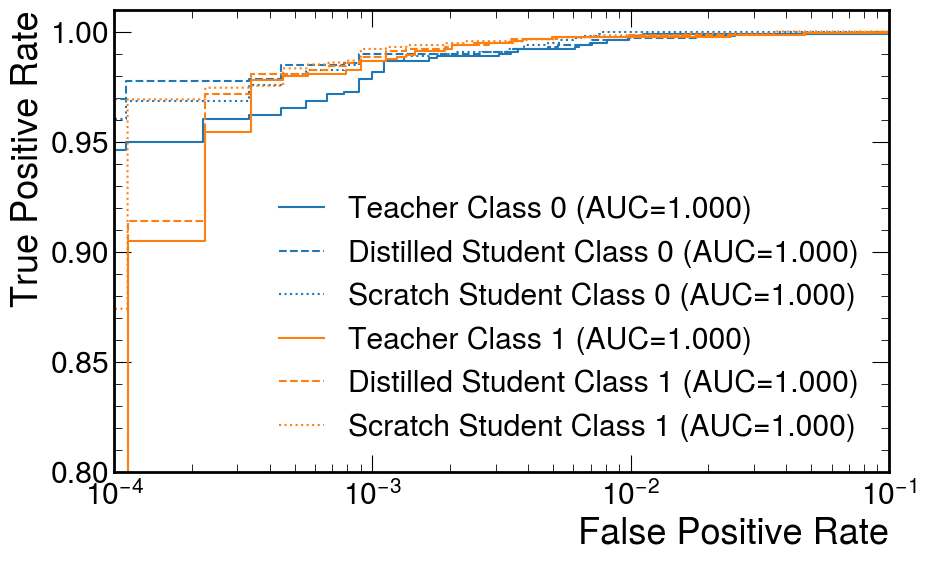

In [ ]:
# Get softmax probabilities for teacher, distilled student, and student trained from skratch
teacher_probs = tf.nn.softmax(teacher(x_test), axis=1).numpy()
student_probs = tf.nn.softmax(student(x_test), axis=1).numpy()
student_scratch_probs = tf.nn.softmax(student_scratch(x_test), axis=1).numpy()

# Classes to plot
classes_to_plot = [0, 1]
colors = plt.cm.tab10(np.linspace(0, 1, 10))

fig, ax = plt.subplots(figsize=(10, 6))

for i in classes_to_plot:
    # Teacher ROC
    fpr_t, tpr_t, _ = roc_curve(y_test_bin[:, i], teacher_probs[:, i])
    auc_t = auc(fpr_t, tpr_t)
    ax.plot(fpr_t, tpr_t, linestyle='-', color=colors[i], label=f'Teacher Class {i} (AUC={auc_t:.3f})')

    # Distilled student ROC
    fpr_s, tpr_s, _ = roc_curve(y_test_bin[:, i], student_probs[:, i])
    auc_s = auc(fpr_s, tpr_s)
    ax.plot(fpr_s, tpr_s, linestyle='--', color=colors[i], label=f'Distilled Student Class {i} (AUC={auc_s:.3f})')

    # Scratch student ROC
    fpr_sc, tpr_sc, _ = roc_curve(y_test_bin[:, i], student_scratch_probs[:, i])
    auc_sc = auc(fpr_sc, tpr_sc)
    ax.plot(fpr_sc, tpr_sc, linestyle=':', color=colors[i], label=f'Scratch Student Class {i} (AUC={auc_sc:.3f})')

# Set axis labels and limits
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_xscale('log')
ax.set_xlim(1e-4, 0.1)   # focus on low false positive rate
ax.set_ylim(0.8, 1.01)   # focus on high true positive rate
ax.legend(loc="lower right")
plt.show()

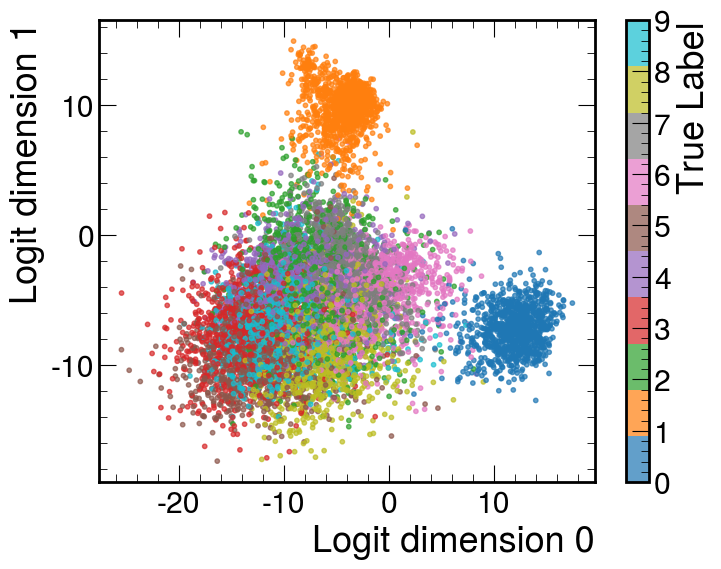

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get logits from student model (shape: [num_samples, 10])
logits = student(x_test).numpy()

# Plot only first two dimensions of logits
plt.figure(figsize=(8, 6))
scatter = plt.scatter(logits[:, 0], logits[:, 1], c=y_test, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("Logit dimension 0")
plt.ylabel("Logit dimension 1")
plt.colorbar(scatter, ticks=range(10), label='True Label')

plt.show()
